In [16]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time
import os

def get_total_results(query="artificial intelligence"):
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results=1"
    response = requests.get(url)
    root = ET.fromstring(response.content)
    total_results = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
    return int(total_results.text) if total_results is not None else 0

def fetch_arxiv_batch(query="artificial intelligence", start=0, max_results=100, retries=3):
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start={start}&max_results={max_results}"
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=30)
            if response.status_code != 200 or not response.content.strip():
                time.sleep(3)
                continue
            root = ET.fromstring(response.content)
            papers = []
            for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
                title = entry.find('{http://www.w3.org/2005/Atom}title').text.strip()
                summary = entry.find('{http://www.w3.org/2005/Atom}summary').text.strip()
                if title and summary:
                    papers.append({"title": title, "abstract": summary})
            return papers
        except Exception as e:
            print(f"Hata oluştu: {e}")
            time.sleep(3)
    return []

query = "artificial intelligence"
total_available = get_total_results(query)
print(f" ArXiv '{query}' için toplam sonuç: {total_available}")

target = min(4000, total_available)
batch_size = 100
all_papers = []

for start in range(0, target, batch_size):
    print(f" {start}-{start+batch_size} çekiliyor...")
    batch = fetch_arxiv_batch(query=query, start=start, max_results=batch_size)
    if not batch:
        print(f" {start}-{start+batch_size} arası boş geldi. Devam ediliyor...")
        continue
    all_papers.extend(batch)
    print(f" Eklendi: {len(batch)} | Toplam: {len(all_papers)}")
    time.sleep(3)

df = pd.DataFrame(all_papers)
df.to_csv("ai_makaleler.csv", index=False)
file_size_mb = os.path.getsize("ai_makaleler.csv") / (1024 * 1024)
print(f"\n Kayıt tamam. Boyut: {file_size_mb:.2f} MB | Toplam makale: {len(df)}")

 ArXiv 'artificial intelligence' için toplam sonuç: 175586
 0-100 çekiliyor...
 Eklendi: 100 | Toplam: 100
 100-200 çekiliyor...
 Eklendi: 100 | Toplam: 200
 200-300 çekiliyor...
 Eklendi: 100 | Toplam: 300
 300-400 çekiliyor...
 Eklendi: 100 | Toplam: 400
 400-500 çekiliyor...
 Eklendi: 100 | Toplam: 500
 500-600 çekiliyor...
 Eklendi: 100 | Toplam: 600
 600-700 çekiliyor...
 Eklendi: 100 | Toplam: 700
 700-800 çekiliyor...
 Eklendi: 100 | Toplam: 800
 800-900 çekiliyor...
 Eklendi: 100 | Toplam: 900
 900-1000 çekiliyor...
 Eklendi: 100 | Toplam: 1000
 1000-1100 çekiliyor...
 Eklendi: 100 | Toplam: 1100
 1100-1200 çekiliyor...
 Eklendi: 100 | Toplam: 1200
 1200-1300 çekiliyor...
 Eklendi: 100 | Toplam: 1300
 1300-1400 çekiliyor...
 1300-1400 arası boş geldi. Devam ediliyor...
 1400-1500 çekiliyor...
 Eklendi: 100 | Toplam: 1400
 1500-1600 çekiliyor...
 Eklendi: 100 | Toplam: 1500
 1600-1700 çekiliyor...
 Eklendi: 100 | Toplam: 1600
 1700-1800 çekiliyor...
 Eklendi: 100 | Toplam: 1700


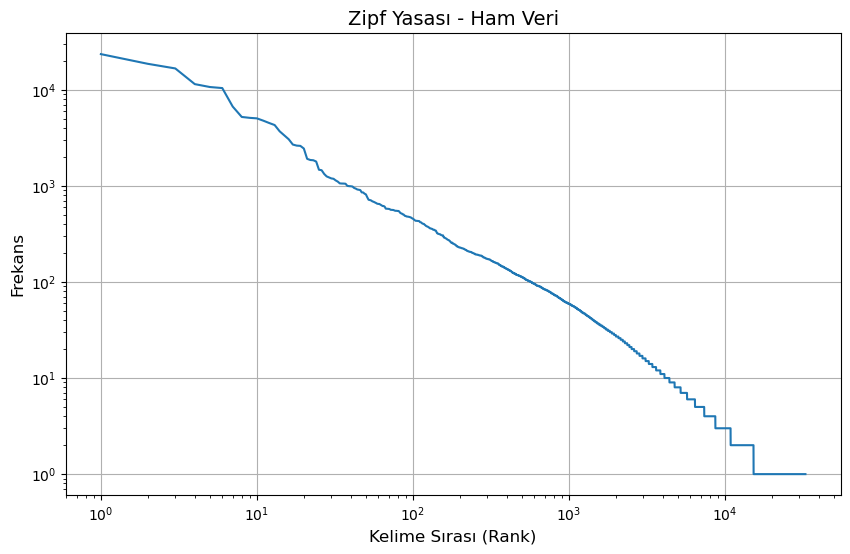

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

df = pd.read_csv("ai_makaleler.csv")
df.dropna(subset=["title", "abstract"], inplace=True)
df["full_text"] = df["title"].astype(str) + ". " + df["abstract"].astype(str)
df["full_text"] = df["full_text"].str.lower()

all_words = ' '.join(df["full_text"].tolist()).split()

word_freq = Counter(all_words)

sorted_freq = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(sorted_freq) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_freq)
plt.xlabel("Kelime Sırası (Rank)", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.title("Zipf Yasası - Ham Veri", fontsize=14)
plt.grid(True)
plt.show()

In [22]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv("ai_makaleler.csv")
df.dropna(subset=["title", "abstract"], inplace=True)

df["full_text"] = df["title"].astype(str) + ". " + df["abstract"].astype(str)

df["full_text"] = df["full_text"].str.lower()

df["sentences"] = df["full_text"].apply(sent_tokenize)
df["tokenized_words"] = df["full_text"].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tokens(tokens):
    cleaned = []
    for word in tokens:
        word = re.sub(r'[^a-z]', '', word) 
        if word and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            cleaned.append(lemma)
    return cleaned

df["clean_tokens"] = df["tokenized_words"].apply(clean_tokens)

df["clean_text"] = df["clean_tokens"].apply(lambda tokens: ' '.join(tokens))

df.to_csv("ai_clean_makaleler.csv", index=False)
print(" Temizlenmiş veri 'ai_clean_makaleler.csv' dosyasına kaydedildi.")

print("\n İlk 3 Temizlenmiş Metin:\n")
for i in range(3):
    print(f"--- Makale {i+1} ---")
    print(df.loc[i, "clean_text"][:500] + "...\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onnal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onnal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\onnal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 Temizlenmiş veri 'ai_clean_makaleler.csv' dosyasına kaydedildi.

 İlk 3 Temizlenmiş Metin:

--- Makale 1 ---
governance physical artificial intelligence physical artificial intelligence prove one important challenge artificial intelligence governance physical artificial intelligence would define responsible intelligent application society...

--- Makale 2 ---
artificial intelligence perform market manipulation discretion genetic algorithm learns artificial market simulation charged responsibility artificial intelligence performing market manipulation discussed study constructed artificial intelligence using genetic algorithm learns artificial market simulation investigated whether artificial intelligence discovers market manipulation learning artificial market simulation despite builder artificial intelligence intention market manipulation result art...

--- Makale 3 ---
impact artificial intelligence economic theory artificial intelligence impacted many aspect human life paper study 

In [23]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

df = pd.read_csv("ai_clean_makaleler.csv")

stemmer = PorterStemmer()

def stem_tokens(text):
    tokens = word_tokenize(text)
    stems = [stemmer.stem(token) for token in tokens if token.isalpha()]
    return stems

df["stemmed_tokens"] = df["clean_text"].apply(stem_tokens)
df["stemmed_text"] = df["stemmed_tokens"].apply(lambda x: ' '.join(x))

final_df = df[["title", "abstract", "stemmed_text", "stemmed_tokens"]]
final_df.to_csv("stemmed_data.csv", index=False)

print(" Tüm stemmed veri tek dosyada 'stemmed_data.csv' olarak kaydedildi.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onnal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Tüm stemmed veri tek dosyada 'stemmed_data.csv' olarak kaydedildi.


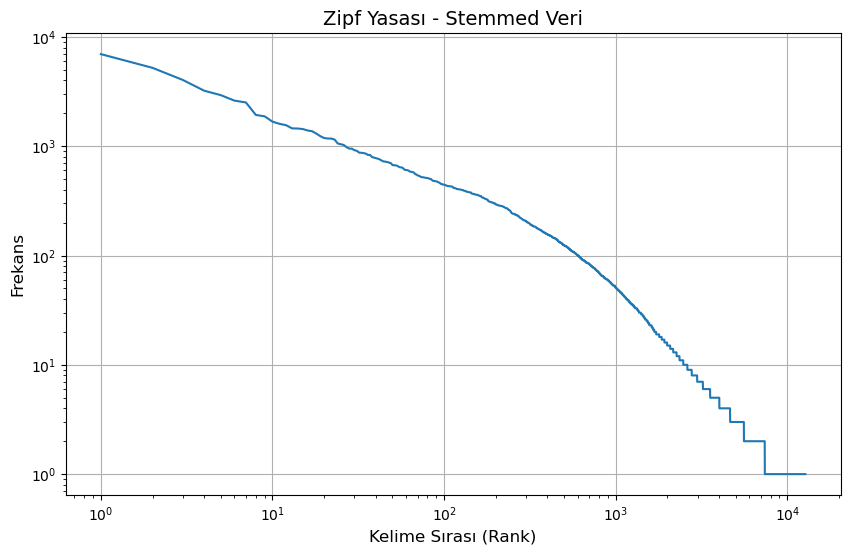

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("stemmed_data.csv")

all_words = ' '.join(df["stemmed_text"].dropna().astype(str).tolist()).split()

word_freq = Counter(all_words)
sorted_freq = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(sorted_freq) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_freq)
plt.xlabel("Kelime Sırası (Rank)", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.title("Zipf Yasası - Stemmed Veri", fontsize=14)
plt.grid(True)
plt.show()

In [33]:
import pandas as pd

df = pd.read_csv("ai_clean_makaleler.csv")

lemma_df = df[["title", "abstract", "clean_text", "clean_tokens"]]

lemma_df.to_csv("lemmatized_data.csv", index=False)

print(" Lemmatized veri 'lemmatized_data.csv' olarak kaydedildi.")


 Lemmatized veri 'lemmatized_data.csv' olarak kaydedildi.


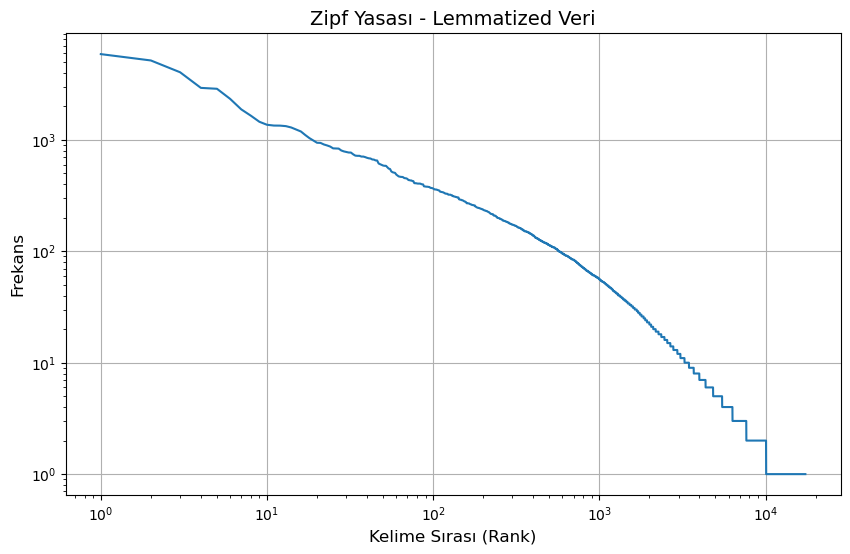

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("ai_clean_makaleler.csv")

all_words = ' '.join(df["clean_text"].dropna().astype(str).tolist()).split()

word_freq = Counter(all_words)
sorted_freq = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(sorted_freq) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_freq)
plt.xlabel("Kelime Sırası (Rank)", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.title("Zipf Yasası - Lemmatized Veri", fontsize=14)
plt.grid(True)
plt.show()

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df_lemma = pd.read_csv("lemmatized_data.csv")
documents_lemma = df_lemma["clean_text"].dropna().astype(str).tolist()

vectorizer_lemma = TfidfVectorizer(max_features=10000)
tfidf_matrix_lemma = vectorizer_lemma.fit_transform(documents_lemma)

tfidf_df_lemma = pd.DataFrame(tfidf_matrix_lemma.toarray(), columns=vectorizer_lemma.get_feature_names_out())
tfidf_df_lemma.to_csv("tfidf_lemmatized.csv", index=False)
print(" tfidf_lemmatized.csv kaydedildi.")

 tfidf_lemmatized.csv kaydedildi.


In [35]:
df_stem = pd.read_csv("stemmed_data.csv")
documents_stem = df_stem["stemmed_text"].dropna().astype(str).tolist()

vectorizer_stem = TfidfVectorizer(max_features=10000)
tfidf_matrix_stem = vectorizer_stem.fit_transform(documents_stem)

tfidf_df_stem = pd.DataFrame(tfidf_matrix_stem.toarray(), columns=vectorizer_stem.get_feature_names_out())
tfidf_df_stem.to_csv("tfidf_stemmed.csv", index=False)
print(" tfidf_stemmed.csv kaydedildi.")

 tfidf_stemmed.csv kaydedildi.


In [36]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import ast
from gensim.models import Word2Vec

df_lemma = pd.read_csv("lemmatized_data.csv")
df_lemma["clean_tokens"] = df_lemma["clean_tokens"].apply(ast.literal_eval)
tokenized_corpus_lemmatized = df_lemma["clean_tokens"].tolist()

df_stem = pd.read_csv("stemmed_data.csv")
df_stem["stemmed_tokens"] = df_stem["stemmed_tokens"].apply(ast.literal_eval)
tokenized_corpus_stemmed = df_stem["stemmed_tokens"].tolist()

parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300}
]

def train_and_save_model(corpus, params, model_prefix):
    model = Word2Vec(
        corpus,
        vector_size=params['vector_size'],
        window=params['window'],
        min_count=1,
        sg=1 if params['model_type'] == 'skipgram' else 0
    )
    filename = f"{model_prefix}_{params['model_type']}_window{params['window']}_dim{params['vector_size']}.model"
    model.save(filename)
    print(f" {filename} kaydedildi.")
    return filename 

model_paths = []

print("\n LEMMATIZED MODELLER:")
for param in parameters:
    path = train_and_save_model(tokenized_corpus_lemmatized, param, "lemmatized_model")
    model_paths.append(path)

print("\n STEMMED MODELLER:")
for param in parameters:
    path = train_and_save_model(tokenized_corpus_stemmed, param, "stemmed_model")
    model_paths.append(path)

print("\n Örnek Benzer Kelimeler (\"intelligence\"):\n")
for path in model_paths:
    print(f"\n Model: {path}")
    model = Word2Vec.load(path)
    if "intelligence" in model.wv.key_to_index:
        similar = model.wv.most_similar("intelligence", topn=5)
        for word, score in similar:
            print(f"{word} ({score:.3f})")
    else:
        print(" 'intelligence' kelimesi bu modelde bulunamadı.")



 LEMMATIZED MODELLER:
✅ lemmatized_model_cbow_window2_dim100.model kaydedildi.
✅ lemmatized_model_skipgram_window2_dim100.model kaydedildi.
✅ lemmatized_model_cbow_window4_dim100.model kaydedildi.
✅ lemmatized_model_skipgram_window4_dim100.model kaydedildi.
✅ lemmatized_model_cbow_window2_dim300.model kaydedildi.
✅ lemmatized_model_skipgram_window2_dim300.model kaydedildi.
✅ lemmatized_model_cbow_window4_dim300.model kaydedildi.
✅ lemmatized_model_skipgram_window4_dim300.model kaydedildi.

 STEMMED MODELLER:
✅ stemmed_model_cbow_window2_dim100.model kaydedildi.
✅ stemmed_model_skipgram_window2_dim100.model kaydedildi.
✅ stemmed_model_cbow_window4_dim100.model kaydedildi.
✅ stemmed_model_skipgram_window4_dim100.model kaydedildi.
✅ stemmed_model_cbow_window2_dim300.model kaydedildi.
✅ stemmed_model_skipgram_window2_dim300.model kaydedildi.
✅ stemmed_model_cbow_window4_dim300.model kaydedildi.
✅ stemmed_model_skipgram_window4_dim300.model kaydedildi.

 Örnek Benzer Kelimeler ("intelligen

In [38]:
#"Stemming işlemi sonucunda, bazı kelimeler kök haline indirgenmiş ve özgün formlarını kaybetmiştir. Örneğin 'intelligence' kelimesi 'intellig' olarak kaydedilmiş, bu yüzden modellerde doğrudan 'intelligence' kelimesi bulunamamıştır. Bu durum, stemming yönteminin bilgi kaybı potansiyelini göstermektedir."

In [40]:
from gensim.models import Word2Vec

stemmed_model_paths = [
    "stemmed_model_cbow_window2_dim100.model",
    "stemmed_model_skipgram_window2_dim100.model",
    "stemmed_model_cbow_window4_dim100.model",
    "stemmed_model_skipgram_window4_dim100.model",
    "stemmed_model_cbow_window2_dim300.model",
    "stemmed_model_skipgram_window2_dim300.model",
    "stemmed_model_cbow_window4_dim300.model",
    "stemmed_model_skipgram_window4_dim300.model"
]

for path in stemmed_model_paths:
    print(f"\n Model: {path}")
    model = Word2Vec.load(path)

    if "intellig" in model.wv.key_to_index:
        print(f" 'intellig' bulundu. En benzer 5 kelime:")
        for word, score in model.wv.most_similar("intellig", topn=5):
            print(f"  {word} ({score:.3f})")
    else:
        print(" 'intellig' kelimesi bu modelde bulunamadı.")



 Model: stemmed_model_cbow_window2_dim100.model
 'intellig' bulundu. En benzer 5 kelime:
  immun (0.919)
  intelligencedriven (0.904)
  intelligenceen (0.883)
  ai (0.881)
  intelligencebas (0.879)

 Model: stemmed_model_skipgram_window2_dim100.model
 'intellig' bulundu. En benzer 5 kelime:
  intelligencebas (0.862)
  immun (0.832)
  blockchain (0.831)
  chemistri (0.829)
  advent (0.827)

 Model: stemmed_model_cbow_window4_dim100.model
 'intellig' bulundu. En benzer 5 kelime:
  immun (0.864)
  intelligencemachin (0.860)
  agi (0.857)
  integr (0.850)
  stupid (0.846)

 Model: stemmed_model_skipgram_window4_dim100.model
 'intellig' bulundu. En benzer 5 kelime:
  advent (0.830)
  pursuit (0.827)
  chemistri (0.825)
  begin (0.820)
  quest (0.816)

 Model: stemmed_model_cbow_window2_dim300.model
 'intellig' bulundu. En benzer 5 kelime:
  facebas (0.931)
  intelligenceautonom (0.927)
  intelligencemedi (0.927)
  facto (0.920)
  intelligenceassist (0.910)

 Model: stemmed_model_skipgram_w